In [25]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import pandas as pd
import numpy as np 
from functools import partial
import plotly.offline as py
py.init_notebook_mode(connected=True)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Step 1 - Use all variables

In [48]:
features_df = pd.read_csv("bitcoin_train.csv")
features_df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Daily_Change,Daily_Change_Ind,MACD,...,Daily_Change_Perc_Gold,Increased_Gold,RSI_Gold,Close/Last_SP500,Open_SP500,Daily_Change_SP500,Daily_Change_Perc_SP500,Increased_SP500,RSI_SP500,label
0,268,2015-11-30,371.437012,382.363007,370.382996,377.321014,71701600,6.027008,1.0,10.296558,...,0.008807,1,33.968948,2080.41,2090.95,-10.54,-0.005041,0,57.384705,0.0
1,1016,2018-11-15,5736.149902,5774.819824,5358.379883,5648.029785,7032140000,-90.320313,0.0,-121.126607,...,0.002641,1,48.296230,2730.20,2693.52,36.68,0.013618,1,59.599184,0.0
2,1144,2019-05-23,7677.269043,7943.791504,7533.196777,7881.846680,24457107820,201.780274,1.0,625.729133,...,0.009777,1,53.162762,2822.24,2836.70,-14.46,-0.005097,0,41.547984,1.0
3,1082,2019-02-25,3807.002441,3913.707275,3807.002441,3882.696289,9318796067,72.268799,1.0,94.876946,...,-0.001802,0,58.979842,2796.11,2804.35,-8.24,-0.002938,0,45.563129,0.0
4,1149,2019-05-31,8320.286133,8586.659180,8172.550781,8574.501953,25365190957,255.029297,1.0,608.732748,...,0.013842,1,63.288965,2752.06,2766.15,-14.09,-0.005094,0,20.448755,0.0


In [49]:
features_df.columns

# feature_lst = ['Daily_Change', 'Daily_Change_Ind', 'MACD', 'PROC_3', 'PROC_5','PROC_10', 'wpr',\
#                 'sto_os', 'goog_trend_score', 'retweets_count', \
#                 'replies_count', 'Daily_Change_Perc', \
#                 'Daily_Change_Perc_Gold', \
#                 'Daily_Change_SP500', 'Daily_Change_Perc_SP500', \
#                 'compound_weighted', 'compound_weighted_avg7', \
#                 'compound_weighted_daily_diff' , 'compound_weighted_weekly_diff',
#                 'replies_count_daily_diff', 'replies_count_avg7', 'replies_count_weekly_diff',
#                 'count', 'count_daily_diff', 'count_weekly_diff', 'RSI']

feature_lst = ['MACD', 'PROC_3', 'PROC_10', 'wpr',\
                'sto_os', 'goog_trend_score', 'retweets_count', \
                'replies_count', 'Daily_Change_Perc', \
                'Daily_Change_Perc_Gold', \
                'Daily_Change_SP500', \
                'compound_weighted', 'compound_weighted_avg7', \
                'compound_weighted_daily_diff' , 'compound_weighted_weekly_diff',
                'replies_count_daily_diff', 'replies_count_avg7', 'replies_count_weekly_diff',
                'count', 'count_daily_diff', 'count_weekly_diff', 'RSI']

outcome = features_df.columns[-1]

print(feature_lst)
print(outcome)

['MACD', 'PROC_3', 'PROC_10', 'wpr', 'sto_os', 'goog_trend_score', 'retweets_count', 'replies_count', 'Daily_Change_Perc', 'Daily_Change_Perc_Gold', 'Daily_Change_SP500', 'compound_weighted', 'compound_weighted_avg7', 'compound_weighted_daily_diff', 'compound_weighted_weekly_diff', 'replies_count_daily_diff', 'replies_count_avg7', 'replies_count_weekly_diff', 'count', 'count_daily_diff', 'count_weekly_diff', 'RSI']
label


In [50]:
X = features_df[feature_lst]
y = features_df[outcome]
print(X.shape, y.shape)

(1246, 22) (1246,)


In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 1234)

In [52]:
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
# define the grid of values to search
grid = dict()

param_grids  = {'base_estimator__max_depth':[1,2],
              'n_estimators':[100,500,1000],
              'learning_rate':[0.01,0.1]}

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1234)

# define the grid search procedure
grid_search = GridSearchCV(estimator = model, param_grid = param_grids, n_jobs = -1, cv = cv, scoring = 'accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

mean_results = []
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    mean_results.append(mean)

Best: 0.568112 using {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 500}
0.555929 (0.035275) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 100}
0.550641 (0.037488) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 500}
0.546709 (0.040758) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 1000}
0.550294 (0.042372) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 100}
0.568112 (0.038140) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 500}
0.551380 (0.040120) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 1000}
0.554911 (0.039053) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 100}
0.545985 (0.040310) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 500}
0.550972 (0.036083) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.01

Rerun adaboost with chosen hyperparameters

In [53]:
chosen_depth = list(grid_result.best_params_.values())[0]
chosen_learning_rate = list(grid_result.best_params_.values())[1]
chosen_n = list(grid_result.best_params_.values())[2]
print("chosen_n:", chosen_n)
print("chosen_learning_rate:", chosen_learning_rate)

base_estimator = DecisionTreeClassifier(max_depth = chosen_depth, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)
# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

chosen_n: 500
chosen_learning_rate: 0.1


In [54]:
# Model Accuracy with chosen decision tree depth and chosen hyperparameters
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("CONFUSION:", confusion)

Accuracy: 0.5096153846153846
CONFUSION: [[ 51  90]
 [ 63 108]]


-------------
FINAL TESTING ON COMBINED VARS BITCOIN
____

In [55]:
features_df_test = pd.read_csv("bitcoin_test.csv")
features_df_test.head()
features_df_test.columns

# feature_lst = ['Daily_Change', 'Daily_Change_Ind', 'MACD', 'PROC_3', 'PROC_5','PROC_10', 'wpr',\
#                 'sto_os', 'goog_trend_score', 'retweets_count', \
#                 'replies_count', 'Daily_Change_Perc', \
#                 'Daily_Change_Perc_Gold', \
#                 'Daily_Change_SP500', 'Daily_Change_Perc_SP500', \
#                 'compound_weighted', 'compound_weighted_avg7', \
#                 'compound_weighted_daily_diff' , 'compound_weighted_weekly_diff',
#                 'replies_count_daily_diff', 'replies_count_avg7', 'replies_count_weekly_diff',
#                 'count', 'count_daily_diff', 'count_weekly_diff', 'RSI']

feature_lst = ['MACD', 'PROC_3', 'PROC_10', 'wpr',\
                'sto_os', 'goog_trend_score', 'retweets_count', \
                'replies_count', 'Daily_Change_Perc', \
                'Daily_Change_Perc_Gold', \
                'Daily_Change_SP500', \
                'compound_weighted', 'compound_weighted_avg7', \
                'compound_weighted_daily_diff' , 'compound_weighted_weekly_diff',
                'replies_count_daily_diff', 'replies_count_avg7', 'replies_count_weekly_diff',
                'count', 'count_daily_diff', 'count_weekly_diff', 'RSI']

outcome = features_df_test.columns[-1]

X_test = features_df_test[feature_lst]
y_test = features_df_test[outcome]


In [56]:
chosen_depth = list(grid_result.best_params_.values())[0]
chosen_learning_rate = list(grid_result.best_params_.values())[1]
chosen_n = list(grid_result.best_params_.values())[2]
print("chosen_n:", chosen_n)
print("chosen_learning_rate:", chosen_learning_rate)

base_estimator = DecisionTreeClassifier(max_depth = chosen_depth, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)
# Train Adaboost Classifer
adaboost.fit(X_train, y_train) 

# Predict the response for valid dataset
y_hat = adaboost.predict(X_test)


chosen_n: 500
chosen_learning_rate: 0.1


In [57]:
# Model Accuracy with chosen decision tree depth and chosen hyperparameters
accuracy_score = metrics.accuracy_score(y_test, y_hat)
confusion = metrics.confusion_matrix(y_test, y_hat) 

print("Accuracy:", accuracy_score)
print("CONFUSION:", confusion)

Accuracy: 0.5448717948717948
CONFUSION: [[ 53  82]
 [ 60 117]]


In [58]:
# Calculate precision
precision = confusion[1][1] / (confusion[1][1] + confusion[0][1])
print(precision)

0.5879396984924623


In [59]:
# calculate recall
recall = confusion[1][1] / (confusion[1][1] + confusion[1][0])
print(recall)

0.6610169491525424


In [60]:
# calculate f1
f1 = ((precision * recall) / (precision + recall)) * 2
print(f1)

0.6223404255319149


In [61]:
feature_import = adaboost.feature_importances_
for i in range(len(feature_lst)):
    print(f"{feature_lst[i]}: {feature_import[i]}")

MACD: 0.108
PROC_3: 0.028
PROC_10: 0.056
wpr: 0.026
sto_os: 0.058
goog_trend_score: 0.03
retweets_count: 0.046
replies_count: 0.026
Daily_Change_Perc: 0.02
Daily_Change_Perc_Gold: 0.036
Daily_Change_SP500: 0.038
compound_weighted: 0.04
compound_weighted_avg7: 0.044
compound_weighted_daily_diff: 0.044
compound_weighted_weekly_diff: 0.038
replies_count_daily_diff: 0.05
replies_count_avg7: 0.102
replies_count_weekly_diff: 0.054
count: 0.004
count_daily_diff: 0.036
count_weekly_diff: 0.076
RSI: 0.04


/home/ksarussi/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



[[ 53  82]
 [ 60 117]]


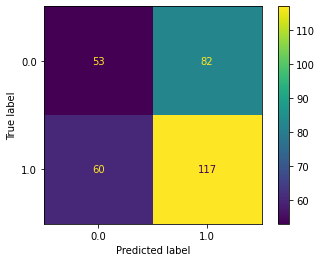

In [62]:
plot_confusion_matrix(adaboost, X_test, y_test)
print(metrics.confusion_matrix(y_test, y_hat))

# Repeat bitcoin financial variables only

In [38]:
features_df = pd.read_csv("bitcoin_train.csv")
features_df.columns

# feature_lst = ['Daily_Change', 'Daily_Change_Ind', 'MACD', 'PROC_3', 'PROC_5','PROC_10', 'wpr',\
#                 'sto_os', 'Daily_Change_Perc', \
#                 'Daily_Change_Perc_Gold', \
#                 'Daily_Change_SP500', 'Daily_Change_Perc_SP500', 'RSI']

feature_lst = ['MACD', 'PROC_3', 'PROC_10', 'wpr',\
                'sto_os', 'Daily_Change_Perc', \
                'Daily_Change_Perc_Gold', \
                'Daily_Change_SP500', 'RSI']


outcome = features_df.columns[-1]

X = features_df[feature_lst]
y = features_df[outcome]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 1234)

In [39]:
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
# define the grid of values to search
grid = dict()
param_grids  = {'base_estimator__max_depth':[1,2],
              'n_estimators':[100,500,1000],
              'learning_rate':[0.01,0.1]}
              
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1234)

# define the grid search procedure
grid_search = GridSearchCV(estimator = model, param_grid = param_grids, n_jobs = -1, cv = cv, scoring = 'accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

mean_results = []
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    mean_results.append(mean)

Best: 0.562755 using {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 500}
0.558084 (0.044169) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 100}
0.562755 (0.037494) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 500}
0.562404 (0.044487) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 1000}
0.561683 (0.047060) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 100}
0.552417 (0.038193) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 500}
0.544578 (0.044534) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 1000}
0.542393 (0.041735) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 100}
0.547072 (0.042463) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 500}
0.535667 (0.036230) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.0

In [40]:
chosen_depth = list(grid_result.best_params_.values())[0]
chosen_learning_rate = list(grid_result.best_params_.values())[1]
chosen_n = list(grid_result.best_params_.values())[2]
print("chosen_n:", chosen_n)
print("chosen_learning_rate:", chosen_learning_rate)

base_estimator = DecisionTreeClassifier(max_depth = chosen_depth, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)
# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

chosen_n: 500
chosen_learning_rate: 0.01


In [41]:
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("CONFUSION:", confusion)

Accuracy: 0.5128205128205128
CONFUSION: [[ 47  94]
 [ 58 113]]


-------------
FINAL TESTING ON FINANCIAL VARS BITCOIN
____

In [42]:
features_df_test = pd.read_csv("bitcoin_test.csv")
features_df_test.head()
features_df_test.columns

feature_lst = ['MACD', 'PROC_3', 'PROC_10', 'wpr',\
                'sto_os', 'Daily_Change_Perc', \
                'Daily_Change_Perc_Gold', \
                'Daily_Change_SP500', 'RSI']

outcome = features_df_test.columns[-1]

X_test = features_df_test[feature_lst]
y_test = features_df_test[outcome]


In [43]:
chosen_depth = list(grid_result.best_params_.values())[0]
chosen_learning_rate = list(grid_result.best_params_.values())[1]
chosen_n = list(grid_result.best_params_.values())[2]
print("chosen_n:", chosen_n)
print("chosen_learning_rate:", chosen_learning_rate)

base_estimator = DecisionTreeClassifier(max_depth = chosen_depth, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)
# Train Adaboost Classifer
adaboost.fit(X_train, y_train) 

# Predict the response for valid dataset
y_hat = adaboost.predict(X_test)

chosen_n: 500
chosen_learning_rate: 0.01


In [44]:
accuracy_score = metrics.accuracy_score(y_test, y_hat)
confusion = metrics.confusion_matrix(y_test, y_hat) 

print("Accuracy:", accuracy_score)
print("CONFUSION:", confusion)

Accuracy: 0.5673076923076923
CONFUSION: [[ 47  88]
 [ 47 130]]


In [45]:
# Calculate precision
precision = confusion[1][1] / (confusion[1][1] + confusion[0][1])
print(precision)

0.5963302752293578


In [46]:
# calculate recall
recall = confusion[1][1] / (confusion[1][1] + confusion[1][0])
print(recall)

0.7344632768361582


In [47]:
# calculate f1
f1 = ((precision * recall) / (precision + recall)) * 2
print(f1)

0.6582278481012659


In [252]:
feature_import = adaboost.feature_importances_
for i in range(len(feature_lst)):
    print(f"{feature_lst[i]}: {feature_import[i]}")

MACD: 0.324
PROC_3: 0.096
PROC_10: 0.202
wpr: 0.064
sto_os: 0.062
Daily_Change_Perc: 0.034
Daily_Change_Perc_Gold: 0.038
Daily_Change_SP500: 0.082
RSI: 0.098


[[ 47  88]
 [ 47 130]]


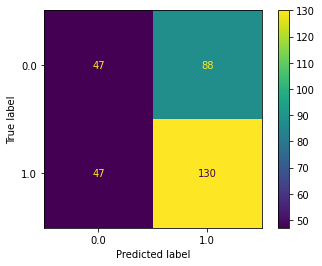

In [253]:
plot_confusion_matrix(adaboost, X_test, y_test)
print(metrics.confusion_matrix(y_test, y_hat))

----------------------------------

# Repeat for tweets vars

In [63]:
features_df = pd.read_csv("bitcoin_train.csv")

feature_lst = [ 'goog_trend_score', 'retweets_count', \
                'replies_count', \
                'compound_weighted', 'compound_weighted_avg7', \
                'compound_weighted_daily_diff' , 'compound_weighted_weekly_diff',
                'replies_count_daily_diff', 'replies_count_avg7', 'replies_count_weekly_diff',
                'count', 'count_daily_diff', 'count_weekly_diff']

outcome = features_df.columns[-1]

print(feature_lst)
print(outcome)

outcome = features_df.columns[-1]

X = features_df[feature_lst]
y = features_df[outcome]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 1234)

['goog_trend_score', 'retweets_count', 'replies_count', 'compound_weighted', 'compound_weighted_avg7', 'compound_weighted_daily_diff', 'compound_weighted_weekly_diff', 'replies_count_daily_diff', 'replies_count_avg7', 'replies_count_weekly_diff', 'count', 'count_daily_diff', 'count_weekly_diff']
label


In [64]:
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
grid = dict()

param_grids  = {'base_estimator__max_depth':[1,2],
              'n_estimators':[100,500,1000],
              'learning_rate':[0.01,0.1]}

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1234)

# define the grid search procedure
grid_search = GridSearchCV(estimator = model, param_grid = param_grids, n_jobs = -1, cv = cv, scoring = 'accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

mean_results = []
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    mean_results.append(mean)

Best: 0.562072 using {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 100}
0.561687 (0.031566) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 100}
0.554568 (0.036579) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 500}
0.561359 (0.036729) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 1000}
0.562072 (0.035564) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 100}
0.556711 (0.037838) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 500}
0.542427 (0.039692) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 1000}
0.539907 (0.042809) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 100}
0.556349 (0.046259) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 500}
0.556017 (0.054875) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.01

In [65]:
chosen_depth = list(grid_result.best_params_.values())[0]
chosen_learning_rate = list(grid_result.best_params_.values())[1]
chosen_n = list(grid_result.best_params_.values())[2]
print("chosen_n:", chosen_n)
print("chosen_learning_rate:", chosen_learning_rate)

base_estimator = DecisionTreeClassifier(max_depth = chosen_depth, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)
# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

chosen_n: 100
chosen_learning_rate: 0.1


In [66]:
# Model Accuracy with chosen decision tree depth and chosen hyperparameters
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("CONFUSION:", confusion)

Accuracy: 0.5
CONFUSION: [[ 30 111]
 [ 45 126]]


-------------
FINAL TESTING ON SOCIAL VARS BITCOIN
____

In [67]:
features_df_test = pd.read_csv("bitcoin_test.csv")
features_df_test.head()
features_df_test.columns

feature_lst = [ 'goog_trend_score', 'retweets_count', \
                'replies_count', \
                'compound_weighted', 'compound_weighted_avg7', \
                'compound_weighted_daily_diff' , 'compound_weighted_weekly_diff',
                'replies_count_daily_diff', 'replies_count_avg7', 'replies_count_weekly_diff',
                'count', 'count_daily_diff', 'count_weekly_diff']

outcome = features_df_test.columns[-1]

X_test = features_df_test[feature_lst]
y_test = features_df_test[outcome]

In [68]:
accuracy_score = metrics.accuracy_score(y_test, y_hat)
confusion = metrics.confusion_matrix(y_test, y_hat) 

print("Accuracy:", accuracy_score)
print("CONFUSION:", confusion)

Accuracy: 0.532051282051282
CONFUSION: [[ 32 103]
 [ 43 134]]


In [69]:
# Calculate precision
precision = confusion[1][1] / (confusion[1][1] + confusion[0][1])
print(precision)

0.5654008438818565


In [70]:
# calculate recall
recall = confusion[1][1] / (confusion[1][1] + confusion[1][0])
print(recall)

0.7570621468926554


In [71]:
# calculate f1
f1 = ((precision * recall) / (precision + recall)) * 2
print(f1)

0.647342995169082


In [260]:
feature_import = adaboost.feature_importances_
for i in range(len(feature_lst)):
    print(f"{feature_lst[i]}: {feature_import[i]}")

goog_trend_score: 0.06
retweets_count: 0.03
replies_count: 0.05
compound_weighted: 0.08
compound_weighted_avg7: 0.16
compound_weighted_daily_diff: 0.14
compound_weighted_weekly_diff: 0.01
replies_count_daily_diff: 0.05
replies_count_avg7: 0.07
replies_count_weekly_diff: 0.1
count: 0.01
count_daily_diff: 0.09
count_weekly_diff: 0.15


[[ 32 103]
 [ 43 134]]


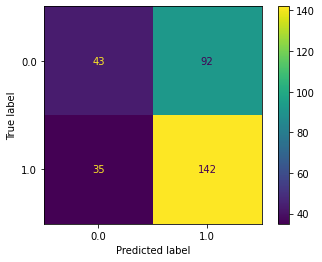

In [261]:
plot_confusion_matrix(adaboost, X_test, y_test)
print(metrics.confusion_matrix(y_test, y_hat))

-------------------------------------------

# Repeat for Dogecoin


In [308]:
dogecoin = pd.read_csv("dogecoin_train.csv")
dogecoin = dogecoin.rename(columns={'goog_trend': 'goog_trend_score'})

# feature_lst = ['Daily_Change', 'Daily_Change_Ind', 'MACD', 'PROC_3', 'PROC_5','PROC_10', 'wpr',\
#                 'sto_os', 'goog_trend_score', 'retweets_count', \
#                 'replies_count', 'Daily_Change_Perc', \
#                 'Daily_Change_Perc_Gold', \
#                 'Daily_Change_SP500', 'Daily_Change_Perc_SP500', \
#                 'compound_weighted', 'compound_weighted_avg7', \
#                 'compound_weighted_daily_diff' , 'compound_weighted_weekly_diff',
#                 'replies_count_daily_diff', 'replies_count_avg7', 'replies_count_weekly_diff',
#                 'count', 'count_daily_diff', 'count_weekly_diff', 'RSI']

feature_lst = ['MACD', 'PROC_3', 'PROC_10', 'wpr',\
                'sto_os', 'goog_trend_score', 'retweets_count', \
                'replies_count', 'Daily_Change_Perc', \
                'Daily_Change_Perc_Gold', \
                'Daily_Change_SP500', \
                'compound_weighted', 'compound_weighted_avg7', \
                'compound_weighted_daily_diff' , 'compound_weighted_weekly_diff',
                'replies_count_daily_diff', 'replies_count_avg7', 'replies_count_weekly_diff',
                'count', 'count_daily_diff', 'count_weekly_diff', 'RSI']

X_dog = dogecoin[feature_lst]
y_dog = dogecoin['label']

X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_dog, y_dog, random_state = 1234)


In [309]:
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
# define the grid of values to search
grid = dict()

param_grids  = {'base_estimator__max_depth':[1,2],
              'n_estimators':[100,500,1000],
              'learning_rate':[0.01,0.1]}

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1234)

# define the grid search procedure
grid_search = GridSearchCV(estimator = model, param_grid = param_grids, n_jobs = -1, cv = cv, scoring = 'accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train2, y_train2)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

mean_results = []
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    mean_results.append(mean)

Best: 0.805308 using {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 100}
0.805308 (0.002443) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 100}
0.803271 (0.007246) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 500}
0.798863 (0.016605) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 1000}
0.800563 (0.017341) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 100}
0.783227 (0.021241) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 500}
0.779503 (0.024621) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 1000}
0.797835 (0.011895) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 100}
0.794097 (0.021190) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 500}
0.788672 (0.023625) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.0

In [264]:
chosen_depth = list(grid_result.best_params_.values())[0]
chosen_learning_rate = list(grid_result.best_params_.values())[1]
chosen_n = list(grid_result.best_params_.values())[2]
print("chosen_n:", chosen_n)
print("chosen_learning_rate:", chosen_learning_rate)

base_estimator = DecisionTreeClassifier(max_depth = chosen_depth, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)
# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

chosen_n: 100
chosen_learning_rate: 0.01


In [265]:
# Model Accuracy with chosen decision tree depth and chosen hyperparameters
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("CONFUSION:", confusion)

Accuracy: 0.7957317073170732
CONFUSION: [[261   0]
 [ 67   0]]


-------------
FINAL TESTING ON COMBINED VARS Dogecoin
____

In [310]:
dogecoin = pd.read_csv("dogecoin_test.csv")
dogecoin = dogecoin.rename(columns={'goog_trend': 'goog_trend_score'})

# feature_lst = ['Daily_Change', 'Daily_Change_Ind', 'MACD', 'PROC_3', 'PROC_5','PROC_10', 'wpr',\
#                 'sto_os', 'goog_trend_score', 'retweets_count', \
#                 'replies_count', 'Daily_Change_Perc', \
#                 'Daily_Change_Perc_Gold', \
#                 'Daily_Change_SP500', 'Daily_Change_Perc_SP500', \
#                 'compound_weighted', 'compound_weighted_avg7', \
#                 'compound_weighted_daily_diff' , 'compound_weighted_weekly_diff',
#                 'replies_count_daily_diff', 'replies_count_avg7', 'replies_count_weekly_diff',
#                 'count', 'count_daily_diff', 'count_weekly_diff', 'RSI']

feature_lst = ['MACD', 'PROC_3', 'PROC_10', 'wpr',\
                'sto_os', 'goog_trend_score', 'retweets_count', \
                'replies_count', 'Daily_Change_Perc', \
                'Daily_Change_Perc_Gold', \
                'Daily_Change_SP500', \
                'compound_weighted', 'compound_weighted_avg7', \
                'compound_weighted_daily_diff' , 'compound_weighted_weekly_diff',
                'replies_count_daily_diff', 'replies_count_avg7', 'replies_count_weekly_diff',
                'count', 'count_daily_diff', 'count_weekly_diff', 'RSI']

X_test = dogecoin[feature_lst]
y_test = dogecoin['label']

print(X_test)


In [267]:
chosen_depth = list(grid_result.best_params_.values())[0]
chosen_learning_rate = list(grid_result.best_params_.values())[1]
chosen_n = list(grid_result.best_params_.values())[2]
print("chosen_n:", chosen_n)
print("chosen_learning_rate:", chosen_learning_rate)

base_estimator = DecisionTreeClassifier(max_depth = chosen_depth, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)
# Train Adaboost Classifer
adaboost.fit(X_train, y_train) 

# Predict the response for valid dataset
y_hat = adaboost.predict(X_test)

chosen_n: 100
chosen_learning_rate: 0.01


In [268]:
# Model Accuracy with chosen decision tree depth and chosen hyperparameters
accuracy_score = metrics.accuracy_score(y_test, y_hat)
confusion = metrics.confusion_matrix(y_test, y_hat) 

print("Accuracy:", accuracy_score)
print("CONFUSION:", confusion)

Accuracy: 0.8140243902439024
CONFUSION: [[267   0]
 [ 61   0]]


In [269]:
feature_import = adaboost.feature_importances_
for i in range(len(feature_lst)):
    print(f"{feature_lst[i]}: {feature_import[i]}")

MACD: 0.57
PROC_3: 0.01
PROC_10: 0.0
wpr: 0.04
sto_os: 0.17
goog_trend_score: 0.03
retweets_count: 0.0
replies_count: 0.0
Daily_Change_Perc: 0.18
Daily_Change_Perc_Gold: 0.0
Daily_Change_SP500: 0.0
compound_weighted: 0.0
compound_weighted_avg7: 0.0
compound_weighted_daily_diff: 0.0
compound_weighted_weekly_diff: 0.0
replies_count_daily_diff: 0.0
replies_count_avg7: 0.0
replies_count_weekly_diff: 0.0
count: 0.0
count_daily_diff: 0.0
count_weekly_diff: 0.0
RSI: 0.0


[[267   0]
 [ 61   0]]


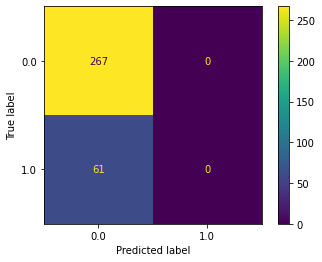

In [270]:
plot_confusion_matrix(adaboost, X_test, y_test)
print(metrics.confusion_matrix(y_test, y_hat))

----------------------

# Repeat Dogecoin financial vars

In [314]:
dogecoin = pd.read_csv("dogecoin_train.csv")
dogecoin = dogecoin.rename(columns={'goog_trend': 'goog_trend_score'})

feature_lst = ['MACD', 'PROC_3', 'PROC_10', 'wpr',\
                'sto_os', 'Daily_Change_Perc', \
                'Daily_Change_Perc_Gold', \
                'Daily_Change_SP500', 'RSI']
X_dog = dogecoin[feature_lst]
y_dog = dogecoin['label']
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X_dog, y_dog, random_state = 1234)


In [315]:
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
# define the grid of values to search
grid = dict()
param_grids  = {'base_estimator__max_depth':[1,2],
              'n_estimators':[100,500,1000],
              'learning_rate':[0.01,0.1]}

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1234)

# define the grid search procedure
grid_search = GridSearchCV(estimator = model, param_grid = param_grids, n_jobs = -1, cv = cv, scoring = 'accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train3, y_train3)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

mean_results = []
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    mean_results.append(mean)

Best: 0.805308 using {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 100}
0.805308 (0.002443) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 100}
0.801574 (0.008337) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 500}
0.800890 (0.020280) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 1000}
0.798509 (0.019777) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 100}
0.786614 (0.025223) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 500}
0.781172 (0.021050) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 1000}
0.801570 (0.014230) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 100}
0.788666 (0.022030) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 500}
0.786968 (0.024020) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.0

In [273]:
chosen_depth = list(grid_result.best_params_.values())[0]
chosen_learning_rate = list(grid_result.best_params_.values())[1]
chosen_n = list(grid_result.best_params_.values())[2]
print("chosen_n:", chosen_n)
print("chosen_learning_rate:", chosen_learning_rate)

base_estimator = DecisionTreeClassifier(max_depth = chosen_depth, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)
# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

chosen_n: 100
chosen_learning_rate: 0.01


In [274]:
# Model Accuracy with chosen decision tree depth and chosen hyperparameters
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("CONFUSION:", confusion)

Accuracy: 0.7957317073170732
CONFUSION: [[261   0]
 [ 67   0]]


-------------
FINAL TESTING ON financial VARS Dogecoin
____

In [275]:
dogecoin = pd.read_csv("dogecoin_test.csv")
dogecoin = dogecoin.rename(columns={'goog_trend': 'goog_trend_score'})

feature_lst = ['MACD', 'PROC_3', 'PROC_10', 'wpr',\
                'sto_os', 'Daily_Change_Perc', \
                'Daily_Change_Perc_Gold', \
                'Daily_Change_SP500', 'RSI']

outcome = features_df.columns[-1]

X_test = dogecoin[feature_lst]
y_test = dogecoin['label']


In [276]:
chosen_depth = list(grid_result.best_params_.values())[0]
chosen_learning_rate = list(grid_result.best_params_.values())[1]
chosen_n = list(grid_result.best_params_.values())[2]
print("chosen_n:", chosen_n)
print("chosen_learning_rate:", chosen_learning_rate)

base_estimator = DecisionTreeClassifier(max_depth = chosen_depth, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)
# Train Adaboost Classifer
adaboost.fit(X_train, y_train) 

# Predict the response for valid dataset
y_hat = adaboost.predict(X_test)

chosen_n: 100
chosen_learning_rate: 0.01


In [277]:
# Model Accuracy with chosen decision tree depth and chosen hyperparameters
accuracy_score = metrics.accuracy_score(y_test, y_hat)
confusion = metrics.confusion_matrix(y_test, y_hat) 

print("Accuracy:", accuracy_score)
print("CONFUSION:", confusion)

Accuracy: 0.8140243902439024
CONFUSION: [[267   0]
 [ 61   0]]


In [278]:
feature_import = adaboost.feature_importances_
for i in range(len(feature_lst)):
    print(f"{feature_lst[i]}: {feature_import[i]}")

MACD: 0.58
PROC_3: 0.01
PROC_10: 0.0
wpr: 0.08
sto_os: 0.15
Daily_Change_Perc: 0.18
Daily_Change_Perc_Gold: 0.0
Daily_Change_SP500: 0.0
RSI: 0.0


[[267   0]
 [ 61   0]]


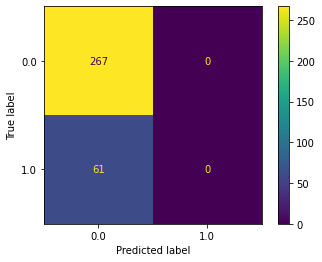

In [279]:
plot_confusion_matrix(adaboost, X_test, y_test)
print(metrics.confusion_matrix(y_test, y_hat))

------------------------

# Repeat Dogecoin social vars

In [7]:
dogecoin = pd.read_csv("dogecoin_train.csv")
dogecoin = dogecoin.rename(columns={'goog_trend': 'goog_trend_score'})

# feature_lst2 = [ 'goog_trend_score', 'retweets_count', \
#                 'replies_count', \
#                 'compound_weighted', 'compound_weighted_avg7', \
#                 'compound_weighted_daily_diff' , 'compound_weighted_weekly_diff',
#                 'replies_count_daily_diff', 'replies_count_avg7', 'replies_count_weekly_diff',
#                 'count', 'count_daily_diff', 'count_weekly_diff']

feature_lst2 = [ 'goog_trend_score', 'MACD']

X_dog6 = dogecoin[feature_lst2]
y_dog6 = dogecoin['label']
X_train4, X_valid4, y_train4, y_valid4 = train_test_split(X_dog6, y_dog6, random_state = 1234)

In [8]:
print(X_dog6)

      goog_trend_score          MACD
0                    7 -3.175818e-05
1                   34  8.710489e-05
2                   49 -1.052540e-04
3                   75 -3.705615e-05
4                   62 -3.519148e-07
...                ...           ...
1304                68  3.146736e-04
1305                49 -1.924366e-07
1306                53 -6.967053e-05
1307                 7 -6.566565e-05
1308                60 -2.600780e-06

[1309 rows x 2 columns]


In [9]:
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
# define the grid of values to search
grid = dict()
param_grids  = {'base_estimator__max_depth':[1,2],
              'n_estimators':[100,500,1000],
              'learning_rate':[0.01,0.1]}

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1234)

# define the grid search procedure
grid_search2 = GridSearchCV(estimator = model, param_grid = param_grids, n_jobs = -1, cv = cv, scoring = 'accuracy')
# execute the grid search
grid_result2 = grid_search2.fit(X_train4, y_train4)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))

# summarize all scores that were evaluated
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']

mean_results = []
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    mean_results.append(mean)

Best: 0.805308 using {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 100}
0.805308 (0.002443) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 100}
0.805308 (0.002443) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 500}
0.804288 (0.004541) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 1000}
0.804288 (0.004541) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 100}
0.786972 (0.022953) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 500}
0.788332 (0.023444) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 1000}
0.802587 (0.012112) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 100}
0.795114 (0.025785) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 500}
0.790682 (0.027770) with: {'base_estimator__max_depth': 2, 'learning_rate': 0.0

In [12]:
chosen_depth = list(grid_result2.best_params_.values())[0]
chosen_learning_rate = list(grid_result2.best_params_.values())[1]
chosen_n = list(grid_result2.best_params_.values())[2]
print("chosen_n:", chosen_n)
print("chosen_learning_rate:", chosen_learning_rate)

base_estimator = DecisionTreeClassifier(max_depth = chosen_depth, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)
# Train Adaboost Classifer
adaboost.fit(X_train4, y_train4)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid4)

chosen_n: 100
chosen_learning_rate: 0.01


In [14]:
# Model Accuracy with chosen decision tree depth and chosen hyperparameters
accuracy_score = metrics.accuracy_score(y_valid4, y_hat)
confusion = metrics.confusion_matrix(y_valid4, y_hat) 

print("Accuracy:", accuracy_score)
print("CONFUSION:", confusion)

Accuracy: 0.7957317073170732
CONFUSION: [[261   0]
 [ 67   0]]


-------------
FINAL TESTING ON social media VARS Dogecoin
____

In [15]:
dogecoin = pd.read_csv("dogecoin_test.csv")
dogecoin = dogecoin.rename(columns={'goog_trend': 'goog_trend_score'})

# feature_lst = [ 'goog_trend_score', 'retweets_count', \
#                 'replies_count', \
#                 'compound_weighted', 'compound_weighted_avg7', \
#                 'compound_weighted_daily_diff' , 'compound_weighted_weekly_diff',
#                 'replies_count_daily_diff', 'replies_count_avg7', 'replies_count_weekly_diff',
#                 'count', 'count_daily_diff', 'count_weekly_diff']

feature_lst2 = [ 'goog_trend_score', 'MACD']

X_test = dogecoin[feature_lst2]
y_test = dogecoin['label']

In [17]:
chosen_depth = list(grid_result2.best_params_.values())[0]
chosen_learning_rate = list(grid_result2.best_params_.values())[1]
chosen_n = list(grid_result2.best_params_.values())[2]
print("chosen_n:", chosen_n)
print("chosen_learning_rate:", chosen_learning_rate)

base_estimator = DecisionTreeClassifier(max_depth = chosen_depth, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)
# Train Adaboost Classifer
adaboost.fit(X_train4, y_train4) 

# Predict the response for valid dataset
y_hat = adaboost.predict(X_test)

chosen_n: 100
chosen_learning_rate: 0.01


In [18]:
# Model Accuracy with chosen decision tree depth and chosen hyperparameters
accuracy_score = metrics.accuracy_score(y_test, y_hat)
confusion = metrics.confusion_matrix(y_test, y_hat) 

print("Accuracy:", accuracy_score)
print("CONFUSION:", confusion)

Accuracy: 0.8140243902439024
CONFUSION: [[267   0]
 [ 61   0]]


In [20]:
feature_import = adaboost.feature_importances_
for i in range(len(feature_lst2)):
    print(f"{feature_lst2[i]}: {feature_import[i]}")

goog_trend_score: 0.07
MACD: 0.93


[[267   0]
 [ 61   0]]


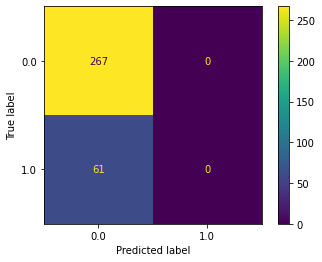

In [288]:
plot_confusion_matrix(adaboost, X_test, y_test)
print(metrics.confusion_matrix(y_test, y_hat))